In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

In [4]:
batch_size = 256
learning_rate = 0.001
num_epochs = 10

In [5]:
mnist_train = dset.MNIST("./", train=True, transform=transforms.ToTensor(), target_transform=None, download=True)
mnist_test = dset.MNIST("./", train=False, transform=transforms.ToTensor(), target_transform=None, download=True)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [6]:
mnist_train

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./
    Split: Train
    StandardTransform
Transform: ToTensor()

In [7]:
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False, num_workers=2, drop_last=True)

In [8]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.layer = nn.Sequential(
        nn.Conv2d(1,16,5), #int_channels, out_channels, kernel_size, stride, padding
        nn.ReLU(),
        nn.Conv2d(16,32,5),
        nn.ReLU(),
        nn.MaxPool2d(2,2),
        nn.Conv2d(32,64,5),
        nn.ReLU(),
        nn.MaxPool2d(2,2)
    )
    self.fc_layer = nn.Sequential(
        nn.Linear(64*3*3,100),
        nn.ReLU(),
        nn.Linear(100,10)
    )

  def forward(self, x):
    out = self.layer(x)
    out = out.view(batch_size, -1)
    out = self.fc_layer(out)
    return out

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [10]:
loss_arr = []
for i in range(num_epochs):
  for j,[image, label] in enumerate(train_loader):
    x = image.to(device)
    y = label.to(device)

    optimizer.zero_grad()
    output = model.forward(x)
    loss = loss_func(output, y)
    loss.backward()
    optimizer.step()

    if j%1000 == 0:
      print(loss)
      loss_arr.append(loss.cpu().detach().numpy())

tensor(2.3054, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0866, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0603, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0564, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0198, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0603, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0372, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0104, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0152, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0087, device='cuda:0', grad_fn=<NllLossBackward>)


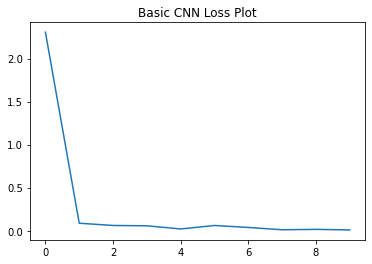

In [11]:
plt.plot(loss_arr)
plt.title("Basic CNN Loss Plot")
plt.show()

In [12]:
correct = 0
total = 0

with torch.no_grad():#기울기를 계산하지 않겠다
  for image, label in test_loader:
    x = image.to(device)
    y = label.to(device)

    output = model.forward(x)
    _, output_index = torch.max(output,1)#최대값과 그 인덱스 값을 구한다.

    total += label.size(0)
    correct += (output_index == y).sum().float()

print("Accuracy of Test Data ; {}".format(100*correct/total))


Accuracy of Test Data ; 99.14863586425781


In [13]:
(output_index == y).sum().float()

tensor(253., device='cuda:0')

### VGGNet
- This Model based on "3*3Conv2d / MaxPooling / FC"

In [14]:
def conv_2_block(in_dim, out_dim):
  model = nn.Sequential(
      nn.Conv2d(in_dim, out_dim, kernel_size=3, padding=1),
      nn.ReLU(),
      nn.Conv2d(in_dim, out_dim, kernel_size=3, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(2,2)
  )
  return model

In [15]:
def conv_3_block(ind_dim, out_dim):
  model = nn.Sequential(
      nn.Conv2d(in_dim, out_dim, kernel_size=3, padding=1),
      nn.ReLU(),
      nn.Conv2d(in_dim, out_dim, kernel_size=3, padding=1),
      nn.ReLU(),
      nn.Conv2d(in_dim, out_dim, kernel_size=3, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(2,2)
  )
  return model

In [16]:
class VGG(nn.Module):
  def __init__(self, base_dim, num_classes=2):
    super(VGG, self).__init__()
    self.layer = nn.Sequential(
        conv_2_block(3,base_dim),
        conv_2_block(base_dim,2*base_dim),
        conv_3_block(2*base_dim,4*base_dim),
        conv_3_block(4*base_dim,8*base_dim),
        conv_3_block(8*base_dim,8*base_dim),
    )
    self.fc_layer = nn.Sequential(
        nn.Linear(8*base_dim*7*7, 100),
        nn.ReLu(True),
        nn.Linear(100,20),
        nn.ReLU(True),
        nn.Linear(20, num_classes)
    )

  def forward(self, x):
    x = self.layer(x)
    x = x.view(x.size(0), -1)
    x = self.fc_layer(x)
    return x

### GoogLeNet
* This Model based on "Inception Module"

In [17]:
def Inception_conv_1(in_dim, out_dim):
  model = nn.Seqeuntial(
      nn.Conv2d(in_dim, out_dim,1,1),
      nn.ReLU()
  )
  return model

In [18]:
def Inception_conv_1_3(in_dim, mid_dim, out_dim):
  model = nn.Seqeuntial(
      nn.Conv2d(in_dim, mid_dim,1,1),
      nn.ReLU(),
      nn.Conv2d(mid_dim, out_dim,3,1,1),
      nn.ReLU()
  )
  return model

In [19]:
def Inception_conv_1_5(in_dim, mid_dim, out_dim):
  model = nn.Seqeuntial(
      nn.Conv2d(in_dim, mid_dim,1,1),
      nn.ReLU(),
      nn.Conv2d(mid_dim, out_dim,5,1,2),
      nn.ReLU()
  )
  return model

In [20]:
def Inception_max_3_1(in_dim, out_dim):
  model = nn.Seqeuntial(
      nn.MaxPool2d(3,1,1),
      nn.Conv2d(in_dim, out_dim,1,1),
      nn.ReLU()
  )
  return model

In [21]:
class inception_moudule(nn.Module):
  def __init__(self, in_dim, out_dim_1, mid_dim_3, out_dim_3, mid_dim_5, out_dim_5, pool):
    super(inception_moudule, self).__init__()

    self.conv_1 = Inception_conv_1(in_dim, out_dim_1)
    self.conv_1_3 = Inception_conv_1_3(in_dim, mid_dim_3, out_dim_3)
    self.conv_1_5 = Inception_conv_1_5(in_dim, mid_dim_5, out_dim_5)
    self.max_3_1 = Inception_max_3_1(in_dim, pool)

  def forward(self, x):
    out_1 = self.conv_1(X)
    out_2 = self.conv_1_3(x)
    out_3 = self.conv_1_5(x)
    out_4 = self.max_3_1(x)
    output = torch.cat([out_1, out_2, out_3, out_4])
    return output

In [22]:
class GoogLeNet(nn.Module):
  def __init__(self, base_dim, num_classes=2):
    super(GoogLeNet, self).__init__()
    self.layer_1 = nn.Sequential(
        nn.Conv2d(3, base_dim,7,2,3),
        nn.MaxPool2d(3,2,1),
        nn.Conv2d(base_dim, base_dim*3,3,1,1),
        nn.MaxPool2d(3,2,1)
    )
    self.layer_2 = nn.Sequential(
        inception_moudule(base_dim*3,64,96,128,16,32,32),
        inception_moudule(base_dim*4,128,128,192,32,96,64),
        nn.MaxPool2d(3,2,1)
    )
    self.layer_3 = nn.Sequential(
        inception_moudule(480,192,96,208,16,48,64),
        inception_moudule(512,160,112,224,24,64,64),
        inception_moudule(512,128,128,256,24,64,64),
        inception_moudule(512,112,144,288,32,64,64),
        inception_moudule(528,256,160,320,32,128,128),
        nn.MaxPool2d(3,2,1)
    )
    self.layer_4 = nn.Sequential(
        inception_moudule(832,256,160,320,32,128,128),
        inception_moudule(832,384,192,384,48,128,128),
        nn.AvgPool2d(7,1)
    )
    self.layer_5 = nn.Dropout2d(0.4)
    self.fc_layer = nn.Linear(1024,1000)

  def forward(self, x):
    out = self.layer_1(x)
    out = self.layer_2(x)
    out = self.layer_3(x)
    out = self.layer_4(x)
    out = self.layer_5(x)
    out = out.view(batch_size, -1)
    out = self.fc_layer(out)

    return out

### ResNet
* This Model based on "Bottle Neck(Short Cut)"

In [23]:
def Resnet_conv_block_1(ind_dim, out_dim, act_fn, stride=1):
  model = nn.Sequential(
      nn.Conv2d(in_dim, out_dim, kernel_size=1, stride=stride),
      act_fn
  )
  return model

In [24]:
def Resnet_conv_block_3(ind_dim, out_dim, act_fn):
  model = nn.Sequential(
      nn.Conv2d(in_dim, out_dim, kernel_size=3, stride=stride, padding=1),
      act_fn
  )
  return model

In [25]:
class BottleNeck(nn.Module):
  def __init__(self, in_dim, mid_dim, out_dim, act_fn, down=False):#down = 블록을 통과했을 때 특성 지도의 크기가 줄어드는 지 여부를 닮은 불리언 변수 / 줄어들 경우 스트라이드가 2가 되어 반으로 줄어듬
    super(BottleNeck, self).__init__()
    self.act_fn = act_fn
    self.down = down

    if self.down:
      self.layer = nn.Sequential(
          Resnet_conv_block_1(in_dim, mid_dim, act_fn, 2),
          Resnet_conv_block_3(mid_dim, mid_dim, act_fn),
          Resnet_conv_block_1(mid_dim, out_dim, act_fn)
      )
      self.downsample = nn.Conv2d(in_dim, out_dim,1,2)
    else:
      self.layer = nn.Sequential(
          Resnet_conv_block_1(in_dim, mid_dim, act_fn, 2),
          Resnet_conv_block_3(mid_dim, mid_dim, act_fn),
          Resnet_conv_block_1(mid_dim, out_dim, act_fn)
      )
      self.dim_equalizer = nn.Conv2d(in_dim, out_dim, kernel_size=1)

    def forward(self, x):
      if self.down:
        downsample = self.downsample(x)
        out = self.layer(x)
        out = out + downsample
      else:
        out = self.layer(x)
        if x.size() is not out.size():
          x = self.dim_equalizer(x)
      out = out + x
    return out

In [28]:
class ResNet(nn.Module):
  def __init__(self, base_dim, num_classes=2):
    super(Resnet, self).__init__()
    self.act_fn = nn.ReLU()
    self.layer_1 = nn.Sequential(
        nn.Conv2d(3, base_dim,7,2,3),
        nn.ReLU(),
        nn.MaxPool2d(3,2,1)
    )
    self.layer_2 = nn.Sequential(
        BottleNeck(base_dim, base_dim, base_dim*4, self.act_fn),
        BottleNeck(base_dim*4, base_dim, base_dim*4, self.act_fn),
        BottleNeck(base_dim*4, base_dim, base_dim*4, self.act_fn, down=True)
    )
    self.layer_3 = nn.Sequential(
        BottleNeck(base_dim*4, base_dim*2, base_dim*8, self.act_fn),
        BottleNeck(base_dim*8, base_dim*2, base_dim*8, self.act_fn),
        BottleNeck(base_dim*8, base_dim*2, base_dim*8, self.act_fn),
        BottleNeck(base_dim*8, base_dim*2, base_dim*8, self.act_fn, down=True)
    )
    self.layer_4 = nn.Sequential(
        BottleNeck(base_dim*8, base_dim*4, base_dim*16, self.act_fn),
        BottleNeck(base_dim*16, base_dim*4, base_dim*16, self.act_fn),
        BottleNeck(base_dim*16, base_dim*4, base_dim*16, self.act_fn),
        BottleNeck(base_dim*16, base_dim*4, base_dim*16, self.act_fn),
        BottleNeck(base_dim*16, base_dim*4, base_dim*16, self.act_fn),
        BottleNeck(base_dim*16, base_dim*4, base_dim*16, self.act_fn, down=True)
    )
    self.layer_5 = bb.Sequential(
        BottleNeck(base_dim*16, base_dim*8, base_dim*32, self.act_fn),
        BottleNeck(base_dim*32, base_dim*8, base_dim*32, self.act_fn),
        BottleNeck(base_dim*32, base_dim*8, base_dim*32, self.act_fn)
    )
    self.avgpool = nn.AvgPool2d(7,1)
    self.fc_layer = nn.Linear(base_dim*32, num_classes)

  def forward(self, x):
    out = self.layer_1(x)
    out = self.layer_2(out)
    out = self.layer_3(out)
    out = self.layer_4(out)
    out = self.layer_5(out)
    out = self.avgpool(out)
    out = out.view(batch_size, -1)
    out = self.fc_layer(out)
    return out
    